In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation 
from celluloid import Camera
from matplotlib import cm

from hamiltonian_gas import HamiltonianGasSystem

In [12]:
dimension: int = 2
num_particles: int = 100
box_size: float = 1.
half_box_size: float = box_size/2

In [13]:
coordinates = (np.random.rand(num_particles, dimension)-half_box_size)*2
momentums = np.random.normal(0, 1, (num_particles, dimension))
coordinates, momentums

(array([[-0.15791575, -0.09242057],
        [ 0.67457155, -0.21339784],
        [ 0.07882996, -0.77518594],
        [ 0.50335071, -0.50852333],
        [ 0.61026707,  0.9366635 ],
        [ 0.67006652, -0.83554054],
        [ 0.82904588, -0.39727815],
        [-0.94728011, -0.03907403],
        [ 0.58039981,  0.0489745 ],
        [-0.39764513, -0.3899189 ],
        [-0.8291659 ,  0.64825976],
        [-0.99627993,  0.33890799],
        [-0.66129014, -0.06237171],
        [ 0.85884674,  0.73851333],
        [-0.49865027, -0.50724308],
        [ 0.67832368, -0.58391629],
        [-0.52240766, -0.56012761],
        [-0.17786346,  0.6398515 ],
        [ 0.21313983,  0.38367278],
        [-0.66209256,  0.63264638],
        [-0.67723699, -0.48961214],
        [-0.09556183,  0.31551025],
        [-0.26327426,  0.78262797],
        [ 0.81998725, -0.98894576],
        [ 0.19606327, -0.37653148],
        [-0.98024923, -0.96134596],
        [ 0.35339062, -0.76048427],
        [ 0.73510477,  0.606

In [4]:
gas = HamiltonianGasSystem(1, 1, 0.01, 0.1)
gas.energy(coordinates, momentums)

4.924679328825802

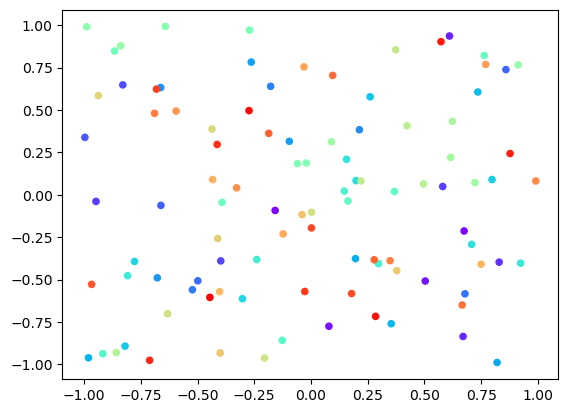

In [14]:
colors = cm.rainbow(np.linspace(0, 1, num_particles))
camera = Camera(plt.figure())
for _ in range(100):
    plt.scatter(*coordinates.T, c=colors, s=20)
    camera.snap()
anim = camera.animate(blit=True)
anim.save('scatter.mp4')